# Covid Data

Dataset containing SARS-CoV-2 T cells described in https://www.medrxiv.org/content/10.1101/2020.12.07.20245274v1

Later available under https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171037

In [1]:
import pandas as pd
import scanpy as sc
import scipy
import anndata
import scirpy as ir
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
sb.set_style('white')

# Single cell data preprocessing

Due to limited amount of cells, the data is not filtered in a similar way as the 10x dataset by expression counts, mitochondrial counts and gene counts.

Only cells are deleted, that have a non-functional / non-unique receptor, since our models can not deal with that.

In [2]:
path_base = '../data/Covid/'
path_raw = path_base + 'Covid19_TAs_PBMCs.h5ad'
path_tcr_split = path_base + '03_covidcovidtrain_test_split.h5ad'
path_highlyvar = path_base + '04_covid_highly_var_5000.h5ad'

## Filter cells with productive single IR 

Filter cells where there is more or less than one alpha and beta chain present

In [3]:
adata = sc.read_h5ad(path_raw)

In [4]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['has_tcr']=='True']
print(f'Number of cells with IR: {adata.n_obs}')

Number of cells: 12503
Number of cells with IR: 11277


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['multi_chain']=='False']

print(f'Number of cells without >2 chains: {adata.n_obs}')

adata = adata[adata.obs['TRA_2_cdr3']=='None']
adata = adata[adata.obs['TRB_2_cdr3']=='None']

print(f'Number of cells with =1 per chain: {adata.n_obs}')

Number of cells: 11277
Number of cells without >2 chains: 11147
Number of cells with =1 per chain: 9853


## Filter unpaired Sequences

In [6]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['TRB_1_cdr3'] != 'None']
print(f'Number of cells with beta chain: {adata.n_obs}')

Number of cells: 9853
Number of cells with beta chain: 9521


In [7]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['TRA_1_cdr3'] != 'None']
print(f'Number of cells with alpha chain: {adata.n_obs}')

Number of cells: 9521
Number of cells with alpha chain: 6713


Sanity check: only a single CDR3alpha and CDR3beta chain is present

In [8]:
def check_invalids(sequence):
    allowed_letters = 'GALMFWKQESPVICYHRNDT'
    for letter in sequence:
        if letter not in allowed_letters:
            return False
    return True

for seq_alpha in adata.obs['TRA_1_cdr3']:
    if not check_invalids(seq_alpha):
        print(seq_alpha)
for seq_beta in adata.obs['TRB_1_cdr3']:
    if not check_invalids(seq_beta):
        print(seq_beta)

## Clonotype Annotation

Give numerica label to each clonotype

In [9]:
adata.obs['TRA+TRB'] = adata.obs['TRA_1_cdr3'].astype(str) + '+' + adata.obs['TRB_1_cdr3'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].value_counts()

Trying to set attribute `.obs` of view, copying.


4102


6       531
12      182
9       158
46      114
31      106
       ... 
2824      1
777       1
2828      1
781       1
2047      1
Name: clonotype, Length: 4102, dtype: int64

## Embed TR

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [10]:
import sys
sys.path.append('../')
import tcr_embedding as tcr
import tcr_embedding.utils_preprocessing as utils

In [11]:
adata.obs['TRA+TRB'] = adata.obs['TRA_1_cdr3'].astype(str) + '+' + adata.obs['TRB_1_cdr3'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

39

In [12]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)


In [13]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

(6713, 41)
(6713, 41, 24)
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}


In [14]:
max_length_alpha = adata.obs['TRA_1_cdr3'].str.len().max()
max_length_beta = adata.obs['TRB_1_cdr3'].str.len().max()
max_length = max(max_length_alpha, max_length_beta)

In [15]:
aa_to_id = adata.uns['aa_to_id']
utils.aa_encoding(adata, read_col='TRA_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='TRB_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)

In [16]:
print(max_length_alpha)
print(max_length_beta)

20
23


## Train-Val-Test Split

Datasets are split s.t. all cells from the same clonotype (here: identical alpha and beta chain) are assigned to the same split. The two samples and the condiation (stimulated vs unstimulated) are distributed evenly over all three sets.

In [17]:
adata.obs['identifier+condition'] = adata.obs['identifier'].astype(str) + '_' + adata.obs['condition'].astype(str)
adata.obs['identifier+condition'].sample(10)

Sample_20063a009_01_GCTGCAGAGCCTATGT    Sample_20063a009_01_unstimulated
Sample_20063a010_01_CGGAGCTGTCCTGCTT      Sample_20063a010_01_stimulated
Sample_20063a010_01_TTTATGCAGCTCAACT      Sample_20063a010_01_stimulated
Sample_20063a009_01_CCACTACCACAGCCCA    Sample_20063a009_01_unstimulated
Sample_20063a010_01_GTGTTAGAGGCTACGA      Sample_20063a010_01_stimulated
Sample_20063a009_01_CCCAGTTGTCTACCTC    Sample_20063a009_01_unstimulated
Sample_20063a009_01_ATCTACTGTGCAGACA    Sample_20063a009_01_unstimulated
Sample_20063a010_01_ATGCGATCATCGACGC      Sample_20063a010_01_stimulated
Sample_20063a009_01_CCAATCCGTTTGGGCC    Sample_20063a009_01_unstimulated
Sample_20063a009_01_CGAGCACTCACCCGAG    Sample_20063a009_01_unstimulated
Name: identifier+condition, dtype: object

In [18]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = utils.stratified_group_shuffle_split(adata.obs, stratify_col='identifier+condition', group_col='clonotype', val_split=0.15, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = utils.stratified_group_shuffle_split(train_val, stratify_col='identifier+condition', group_col='clonotype', val_split=0.15, random_seed=random_seed)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 55.96it/s]


In [19]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  5343
Train Ratio:  0.7959183673469388
Val Samples:  680
Val Ratio:  0.10129599284969462
Test Samples:  690
Test Ratio:  0.10278563980336661


### Visualize Distribution

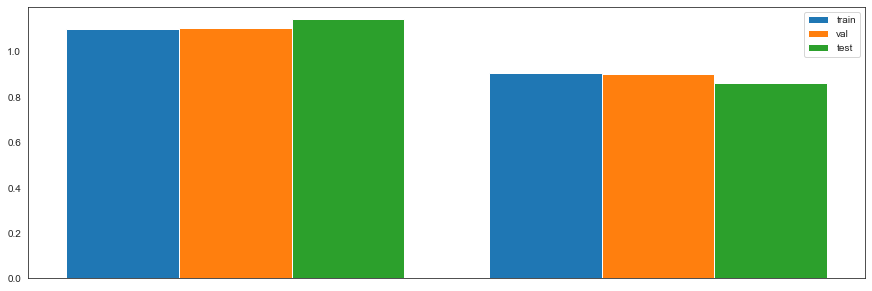

In [20]:
pl.figure(figsize=(15,5))
pl.hist([train['identifier'], val['identifier'], test['identifier']], density=True, bins=len(train['identifier'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

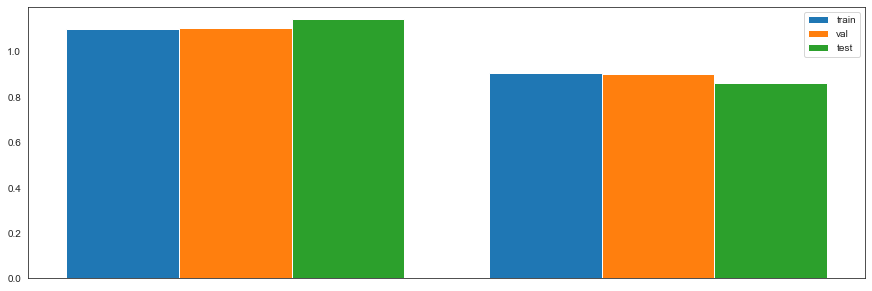

In [21]:
pl.figure(figsize=(15,5))
pl.hist([train['condition'], val['condition'], test['condition']], density=True, bins=len(train['condition'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

In [22]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

train    5343
test      690
val       680
Name: set, dtype: int64

In [23]:
adata.write_h5ad(path_tcr_split, compression='gzip')

... storing 'TRA+TRB' as categorical
... storing 'identifier+condition' as categorical
... storing 'set' as categorical


## Highly Variable Genes

Reduce the expression data to the 5000 most variable genes.

In [24]:
adata = sc.read_h5ad(path_tcr_split)

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key='identifier')
print('Shape before: ', adata.shape)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Shape before:  (6713, 16598)
Shape after:  (6713, 5000)


C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [26]:
sc.write(adata=adata, filename=path_highlyvar)